# Predict low, high strategy  EDA

To install conda and binance packages to this notebook uncomment the code below

In [1]:
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
%pip install binance-connector==1.13.0
%pip install pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:

import os
# Downloading latest bots data
os.system("cd ./../deploy/yandex_cloud; ./bots_get_data.sh")

rsync -v -r yc-user@84.201.128.116:/home/yc-user/biml/data/ /home/dima/projects/biml/deploy/yandex_cloud/../../data/yandex-cloud
receiving incremental file list
LSTMStrategy/LSTMStrategy.db
LSTMStrategy/Xy/2023-05-10_BTCUSDT_X.csv
LSTMStrategy/Xy/2023-05-10_BTCUSDT_data.csv
LSTMStrategy/Xy/2023-05-10_BTCUSDT_y.csv
LSTMStrategy/weights/2023-05-10T20:59:47.450672.data-00000-of-00001
LSTMStrategy/weights/2023-05-10T20:59:47.450672.index
LSTMStrategy/weights/checkpoint

sent 33,774 bytes  received 2,385,875 bytes  967,859.60 bytes/sec
total size is 16,580,059  speedup is 6.85


0

Init binance client

In [3]:
from binance.spot import Spot as Client
import os
import sys
import yaml

# Load 
def load_config():
    """
    Load config from cfg folder respecting the order: defaults, app.yaml, environment vars
    """
    # Defaults
    cfg_dir="./../biml/cfg"
    default_cfg_path = f"{cfg_dir}/app-defaults.yaml"
    with open(default_cfg_path, "r") as appdefaults:
        config = yaml.safe_load(appdefaults)

    # Custom config, should contain custom information,
    cfg_path = f"{cfg_dir}/app.yaml"
    if os.path.exists(cfg_path):
        with open(cfg_path) as app:
            config.update(yaml.safe_load(app))
    else:
        sys.exit(
            f"Config {cfg_path} not found. Please copy cfg/app-defaults.yaml to {cfg_path} "
            f"and update connection info there.")

    # Enviroment variabless
    config.update(os.environ)
    return config

def load_config_yc():
    """
    Load config from cfg folder respecting the order: defaults, app.yaml, environment vars
    """
    project_dir="./.."
    # Defaults
    cfg_path = f"{project_dir}/deploy/yandex_cloud/secret/app.yaml"
    with open(cfg_path, "r") as appdefaults:
        config = yaml.safe_load(appdefaults)
    return config

def create_client(strategy: str):
        # Create binance client
        config=load_config()
        # Uncomment if we are analysing bot from yandex cloud
        config.update(load_config_yc())
        
        strategy=strategy.lower()
        key,secret,url=config[f"biml.connector.{strategy}.key"],config[f"biml.connector.{strategy}.secret"],config["biml.connector.url"]
        return Client(key=key, secret=secret, base_url=url, timeout=10)

#strategy="SimpleKerasStrategy"
strategy="LSTMStrategy"

client = create_client(strategy)



## Account and orders

In [4]:
account=client.account()
usdt_free=[a["free"] for a in account["balances"] if a["asset"]=="USDT"]
# update_time=account["update_time"]
# print(f"account update time:{update_time}")
print(f"My USDT amount: {usdt_free}")

print(account)
print(str(pd.to_datetime(account["updateTime"], unit="ms")))
# btc 1.15798200
#usdt 5134.30859706 26.04.2023 14:26



My USDT amount: ['9999.82493648']
{'makerCommission': 0, 'takerCommission': 0, 'buyerCommission': 0, 'sellerCommission': 0, 'commissionRates': {'maker': '0.00000000', 'taker': '0.00000000', 'buyer': '0.00000000', 'seller': '0.00000000'}, 'canTrade': True, 'canWithdraw': False, 'canDeposit': False, 'brokered': False, 'requireSelfTradePrevention': False, 'updateTime': 1683752338846, 'accountType': 'SPOT', 'balances': [{'asset': 'BNB', 'free': '1000.00000000', 'locked': '0.00000000'}, {'asset': 'BTC', 'free': '1.00000000', 'locked': '0.00000000'}, {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'}, {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'}, {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'}, {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'}, {'asset': 'USDT', 'free': '9999.82493648', 'locked': '0.00000000'}, {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}], 'permissions': ['SPOT']}
2023-05-10 20:58:

My trades from Binance

In [5]:
symbol="BTCUSDT"
mytrades=pd.DataFrame(client.my_trades(symbol))
mytrades["time"] = pd.to_datetime(mytrades["time"], unit='ms')
mytrades.tail(100)


,symbol,id,orderId,orderListId,price,qty,quoteQty,commission,commissionAsset,time,isBuyer,isMaker,isBestMatch
400,BTCUSDT,1100410,3055850,6188,28120.57000000,0.00100000,28.12057000,0.00000000,BTC,2023-05-10 15:04:38.774,True,False,True
401,BTCUSDT,1100434,3055902,-1,28124.99000000,0.00100000,28.12499000,0.00000000,USDT,2023-05-10 15:04:49.750,False,False,True
402,BTCUSDT,1100488,3055907,6189,28132.53000000,0.00100000,28.13253000,0.00000000,BTC,2023-05-10 15:05:20.758,True,False,True
403,BTCUSDT,1105782,3071231,-1,28149.34000000,0.00100000,28.14934000,0.00000000,BTC,2023-05-10 15:58:59.386,True,False,True
404,BTCUSDT,1106301,3071238,6204,28178.42000000,0.00100000,28.17842000,0.00000000,USDT,2023-05-10 16:03:46.941,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,BTCUSDT,1147024,3167688,6357,27863.05000000,0.00100000,27.86305000,0.00000000,USDT,2023-05-10 20:53:23.796,False,True,True
496,BTCUSDT,1147031,3167750,-1,27863.07000000,0.00100000,27.86307000,0.00000000,BTC,2023-05-10 20:53:32.146,True,False,True
497,BTCUSDT,1147042,3167755,6358,27860.99000000,0.00100000,27.86099000,0.00000000,USDT,2023-05-10 20:53:44.819,False,False,True
498,BTCUSDT,1147190,3168314,-1,27867.42000000,0.00100000,27.86742000,0.00000000,BTC,2023-05-10 20:55:29.247,True,False,True


Trades from bot database

In [6]:
import pandas as pd
import numpy as np

def get_trades(strategy: str):
    import sqlite3
    db_path=f"../data/yandex-cloud/{strategy}/{strategy}.db"

    with sqlite3.connect(db_path) as conn:
        trades=pd.read_sql_query("SELECT * FROM trade ORDER BY open_time",conn,
                                 parse_dates=["open_time", "close_time"])#.set_index("open_time", drop=False)
    trades["profit"] = np.where(trades["side"] == "BUY", 
                                (trades["close_price"]-trades["open_price"])*trades["quantity"],
                                (trades["open_price"]-trades["close_price"])*trades["quantity"],
                               )
    return trades

trades=get_trades(strategy)
trades.tail()

,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,profit
1,2,BTCUSDT,BUY,2023-05-10 20:50:49.296963,27873.16,3166963,27870.917392,27878.480435,6355,None,0.001,2023-05-10 20:50:49.904,27870.48,3166968,-0.00268
2,3,BTCUSDT,BUY,2023-05-10 20:51:16.902684,27871.46,3167105,27869.061869,27886.352091,6356,None,0.001,2023-05-10 20:51:56.824,27869.01,3167107,-0.00245
3,4,BTCUSDT,BUY,2023-05-10 20:53:20.182227,27860.19,3167681,27858.411961,27863.050215,6357,None,0.001,2023-05-10 20:53:23.796,27863.05,3167688,0.00286
4,5,BTCUSDT,BUY,2023-05-10 20:53:33.039178,27863.07,3167750,27860.991782,27868.245192,6358,None,0.001,2023-05-10 20:53:44.819,27860.99,3167755,-0.00208
5,6,BTCUSDT,BUY,2023-05-10 20:55:30.137882,27867.42,3168314,27865.485582,27873.716332,6360,None,0.001,2023-05-10 20:58:58.846,27865.43,3168321,-0.00199


In [7]:
print(f"Total profit: {trades['profit'].sum()}")

Total profit: 0.0016700000000018913


Opened trades from trade bot database

In [8]:
trades[trades.close_time.isna()].tail()

,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,profit


In [9]:
#trades[["open_price", "close_price"]].tail()
#(trades["open_price"] - trades["take_profit_price"]).abs().max()
#trades[["open_price", "stop_loss_price"]].info()
#df["stop_loss"] = df["open_price"].astype(float) - df["stop_loss_price"].astype(float)
#df["stop_loss"] = df["stop_loss"].abs()


#df.info()

Last orders, provided by Binance

In [10]:
orders = pd.DataFrame(client.get_orders(symbol))
for timecol in ["time", "updateTime", "workingTime"]:
    orders[timecol] = pd.to_datetime(orders[timecol], unit='ms')
orders.tail()

,symbol,orderId,orderListId,clientOrderId,price,origQty,executedQty,cummulativeQuoteQty,status,timeInForce,type,side,stopPrice,icebergQty,time,updateTime,isWorking,workingTime,origQuoteOrderQty,selfTradePreventionMode
495,BTCUSDT,3167755,6358,znbbbN39jX8jI46DO1zgoA,27582.36000000,0.00100000,0.00100000,27.86099000,FILLED,GTC,STOP_LOSS_LIMIT,SELL,27860.99000000,0.00000000,2023-05-10 20:53:32.910,2023-05-10 20:53:44.819,True,2023-05-10 20:53:44.819,0.00000000,NONE
496,BTCUSDT,3167756,6358,yWW9CmNt2oqLppgysks4xY,27868.25000000,0.00100000,0.00000000,0.00000000,EXPIRED,GTC,LIMIT_MAKER,SELL,0.00000000,0.00000000,2023-05-10 20:53:32.910,2023-05-10 20:53:44.819,True,2023-05-10 20:53:32.910,0.00000000,NONE
497,BTCUSDT,3168314,-1,eCX9oVy5h8ENIesumMLL88,27895.06000000,0.00100000,0.00100000,27.86742000,FILLED,FOK,LIMIT,BUY,0.00000000,0.00000000,2023-05-10 20:55:29.247,2023-05-10 20:55:29.247,True,2023-05-10 20:55:29.247,0.00000000,NONE
498,BTCUSDT,3168321,6360,cp72OfLVvRJiVKaV7iBGvb,27586.82000000,0.00100000,0.00100000,27.86543000,FILLED,GTC,STOP_LOSS_LIMIT,SELL,27865.49000000,0.00000000,2023-05-10 20:55:30.009,2023-05-10 20:58:58.846,True,2023-05-10 20:58:58.846,0.00000000,NONE
499,BTCUSDT,3168322,6360,TjL08zBAuVozloQ0Ns69Bm,27873.72000000,0.00100000,0.00000000,0.00000000,EXPIRED,GTC,LIMIT_MAKER,SELL,0.00000000,0.00000000,2023-05-10 20:55:30.009,2023-05-10 20:58:58.846,True,2023-05-10 20:55:30.009,0.00000000,NONE


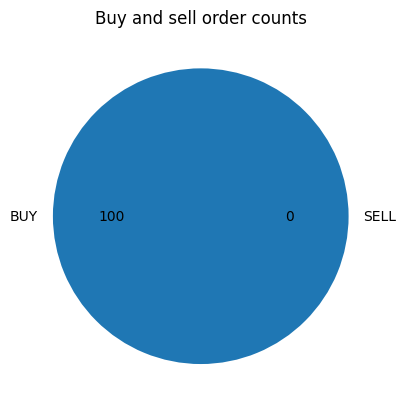

In [11]:
from matplotlib import pyplot as plt
buy_sell_counts = trades["side"].value_counts()
#px.bar(trades["side"].value_counts(), title="Trade counts")
plt.pie([len(trades[trades["side"]=="BUY"]),len(trades[trades["side"]=="SELL"])], 
        labels=["BUY","SELL"],
        autopct="%.0f")
plt.title("Buy and sell order counts")
plt.show()


In [ ]:
import plotly.express as px
buy_profit = trades.loc[trades["side"]=="BUY","profit"]
sell_profit = trades.loc[trades["side"]=="SELL","profit"]
buy_profit = trades.loc[trades["side"]=="BUY","profit"]

#     q_low = df["low"].diff().quantile(0.01)
#     q_high  = df["high"].diff().quantile(0.99)
#     df=df[df["high"].diff()< q_high]
#     df=df[df["low"].diff() > q_low ]
px.bar(x=["buy_profit_sum", "sell_profit_sum"], y=[buy_profit.sum(), sell_profit.sum()], title="Buy or sell profit sum")

In [ ]:
import plotly.express as px
buy_profit = trades.loc[trades["side"]=="BUY","profit"].mean()
sell_profit = trades.loc[trades["side"]=="SELL","profit"].mean()
px.bar(x=["buy_profit", "sell_profit"], y=[buy_profit, sell_profit], title="Buy or sell average trade profit")

## Trades on candlestick chart

In [14]:
from datetime import datetime
def get_last_candles():
    candle_columns = ["open_time", "open", "high", "low", "close", "vol", "close_time", "quote_asset_volume",
                      "number_of_trades", " taker_buy_base_asset_volume", "taker_buy_quote_asset_volume",
                      "ignore"]    
    end_date=trades.open_time.max() if not trades.empty else datetime.utcnow()
    
    #end_time_millis=end_date.value//1000000
    cnt=24*60 # Number of last candles to read
    raw_candles = client.klines(symbol=symbol,
                                    interval="1m",
                                    #limit=10,
                                    limit=cnt,
                                    #endTime=end_time_millis
                               )
    df = pd.DataFrame(raw_candles, columns=candle_columns)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df.set_index("open_time", drop=False, inplace=True)
        # Convert strings to float prices
    df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]].astype(float)
    return df

def clean_candles(df):
    """ Remove outliers """
    q_low = df["low"].diff().quantile(0.1)
    q_high  = df["high"].diff().quantile(0.9)
    df=df[df["high"].diff()< q_high]
    df=df[df["low"].diff() > q_low ]
    return df

candles = get_last_candles()
candles = clean_candles(candles)
candles.tail()

,open_time,open,high,low,close,vol,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
open_time,,,,,,,,,,,,
2023-05-10 20:55:00,2023-05-10 20:55:00,27867.42,27872.21,27866.76,27872.20,3.14691300,2023-05-10 20:55:59.999,87698.85750212,102,1.10437500,30778.69038616,0
2023-05-10 20:56:00,2023-05-10 20:56:00,27872.21,27872.21,27866.56,27867.40,0.95735200,2023-05-10 20:56:59.999,26679.14054314,30,0.18642000,5194.89113800,0
2023-05-10 20:57:00,2023-05-10 20:57:00,27867.41,27867.41,27866.56,27867.09,0.48837000,2023-05-10 20:57:59.999,13609.30625499,18,0.44783200,12479.65164571,0
2023-05-10 20:58:00,2023-05-10 20:58:00,27867.41,27871.73,27865.23,27865.23,2.03168000,2023-05-10 20:58:59.999,56618.46515937,67,1.14468500,31901.15235763,0
2023-05-10 21:00:00,2023-05-10 21:00:00,27857.23,27863.82,27857.11,27863.82,1.20821000,2023-05-10 21:00:59.999,33658.59919812,48,1.06781400,29747.56412970,0


In [15]:
# Install a conda package in the current Jupyter kernel
#%conda install -c plotly plotly=5.9.0
# Draw candlechart
import plotly as py
from plotly import graph_objects as go
import pandas as pd
import numpy as np
import datetime

def get_chart_figure(candles: pd.DataFrame, trades: pd.DataFrame)->pd.DataFrame:
    """
    Form plotly candlestick chart with buy/sell marks on it
    """
    
    df=candles.copy()
    #df=clean_candles(df)
    fig = go.Figure(data=[ \
                        go.Candlestick(\
                            x=df.index,\
                            open=df['open'],\
                            high=df['high'],\
                            low=df['low'],\
                            close=df['close'])
                         ])

    # Customize ay to distribute captions by y so they do not overlap by x
    ay,aymax,aystep=0,50,10
    #start_time=df.open_time.min()
    # Annotate buy, sell on the chart
    for i,trade in trades[(~trades.open_time.isna()) & (trades.open_time > df.open_time.min())].iterrows():
        ay=(ay+aystep)%aymax
        color='green' if trade['side']=="BUY" else 'red'

        # Draw open order
        open_text='buy' if trade['side']=="BUY"  else 'sell'
        open_hover=f"{trade['open_time']} {open_text} at {str(trade['open_price'])}, sl={trade['stop_loss_price']}, tp={trade['take_profit_price']}"
        fig.add_annotation(x=trade['open_time'], \
                           y=trade['open_price'],\
                           text=open_text,\
                           hovertext=open_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,
                           font={'color':color}
                          )
    for i,trade in trades[(~trades.close_time.isna()) & (trades.close_time > df.close_time.min())].iterrows():
        color='green' if trade['side']=="BUY" else 'red'

        # Draw close order
        #profit = trade["close_price"]-trade["open_price"] if trade["close_price"] else None
        status= f", profit: {round(trade.profit, 10)}" if trade.profit else ""
        close_text='close buy' if trade['side']=="BUY"  else 'close sell'
        close_hover=f"{trade['close_time']} {close_text} at {str(trade['close_price'])}{status}"
        fig.add_annotation(x=trade['close_time'], \
                           y=trade['close_price'],\
                           text=close_text,\
                           hovertext=close_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,
                           font={'color':color}
                          )
    return fig

get_chart_figure(candles, trades).show()



## Profit

In [16]:
import matplotlib.pyplot as plt
import plotly.express as px

profit=trades[["open_time", "profit"]].copy()


# mean = profit["profit"].mean()
# sd = profit["profit"].std()
# n_std=2
        
# profit = profit[(profit["profit"].abs() <= mean+(n_std*sd))]
profit["cum_profit"] = profit["profit"].cumsum()

In [17]:
px.line(trades, x="open_time", y="profit")


In [18]:

px.line(profit, x="open_time", y= "cum_profit")

In [19]:
import seaborn as sns


colors = sns.color_palette('pastel')[0:5]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Profit/loss trade counts')
ax1.pie([len(trades[(trades["side"]=="BUY") &  (trades["profit"]>0)].index),\
        len(trades[(trades["side"]=="BUY") &  (trades["profit"]<0)].index) \
        ],
        labels=["buy profit", " buy loss"], autopct="%.0f%%", colors=colors)
ax2.pie([len(trades[(trades["side"]=="SELL") &  (trades["profit"]>0)].index),\
        len(trades[(trades["side"]=="SELL") &  (trades["profit"]<0)].index) \
        ],
        labels=["sell profit", " sell loss"], autopct="%.0f%%", colors=colors)


plt.show()
#trades[trades["profit"]>0].count()


/home/dima/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3050: RuntimeWarning:

invalid value encountered in true_divide



ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 640x480 with 2 Axes>

In [ ]:
trades[trades["profit"]>0]["profit"].median()
#trades[trades["profit"]<0]["profit"].median()

## Predicted and actual low/high

In [ ]:
import os
import glob
import pandas as pd
from datetime import timedelta,date
import matplotlib.pyplot as plt
import plotly.express as px

def read_last_data(strategy):
    """ Read days from start to end from local predictions history"""
    
    def read_last(symbol: str, name: str, n: int):
        data_dir=f"./../data/{strategy}/Xy"
        file_path = sorted([f for f in os.listdir(data_dir) if f.endswith(f"{symbol}_{name}.csv")])[-1]
        return pd.read_csv(f"{data_dir}/{file_path}", parse_dates=True, index_col="datetime").tail(n)
    n=1000
    data=read_last("BTCUSDT", "data", n)
    X=read_last("BTCUSDT", "X", n)
    y=read_last("BTCUSDT", "y", n)
    data=pd.merge(data[["symbol"]],y, left_index=True, right_index=True) 
    #y=pd.concat([data,y])
    return data,X,y


# Read candles for last 3 days
data,_,_ = read_last_data(strategy)
data.tail(100)

In [ ]:

def get_predictions(data):
    """ 
    Merge predicted and real prices for analysis 
    """
    
    # Prediction window is constant, get it from last row
    predicted=data[["bid","ask","bid_min_fut", "bid_max_fut", "ask_min_fut", "ask_max_fut"]]
    predicted.columns=[c.replace("_fut", "_predicted") for c in predicted.columns]
    predict_window=data["predict_window"].tail(1).values[0]
    real_min=data[["bid", "ask"]].rolling(predict_window).min().rename(columns={"bid":"bid_min_real", "ask":"ask_min_real"})
    real_max=data[["bid", "ask"]].rolling(predict_window).max().rename(columns={"bid":"bid_max_real", "ask":"ask_max_real"})
    real=pd.concat([real_min, real_max], axis=1)
    real["prediction_datetime"]=real.index.to_series()-pd.to_timedelta(predict_window)
    merged=pd.merge_asof(real, predicted, left_on="prediction_datetime", right_index=True, direction='forward')
    return merged[["bid", "ask", "bid_min_real", "bid_min_predicted", "bid_max_real", "bid_max_predicted", \
                   "ask_min_real", "ask_min_predicted", "ask_max_real", "ask_max_predicted"]]


# predicted=data[["bid","ask","bid_min_fut", "bid_max_fut", "ask_min_fut", "ask_max_fut"]]
# predicted.columns=[c.replace("_fut", "_predicted") for c in predicted.columns]
# predict_window=data["predict_window"].tail(1).values[0]
# real_min=data[["bid", "ask"]].rolling(predict_window).min().rename(columns={"bid":"bid_min_real", "ask":"ask_min_real"})
# real_max=data[["bid", "ask"]].rolling(predict_window).max().rename(columns={"bid":"bid_max_real", "ask":"ask_max_real"})
# real=pd.concat([real_min, real_max], axis=1)
# real["prediction_datetime"]=real.index.to_series()-pd.to_timedelta(predict_window)

# pd.merge_asof(real, predicted, left_on="prediction_datetime", right_index=True, direction='backward')


predictions = get_predictions(data)
predictions.info()


## Prediction errors

In [ ]:
def plot_prediction_err(predictions):
    df = pd.DataFrame(index=predictions.index)
    for bidask in ["bid", "ask"]:
        for maxmin in ["max", "min"]:
            prefix = f"{bidask}_{maxmin}"
            df[f"{prefix}_error"] = predictions[f"{prefix}_predicted"] - predictions[f"{prefix}_real"]
    
    px.line(df, title="Errors", markers=True).show()
    px.line(df.sum(axis=1).abs().rename("error sum"), title="Error summary", markers=True).show()
    
plot_prediction_err(predictions)

In [ ]:
import pandas as pd

def get_profits(predictions: pd.DataFrame)->pd.DataFrame:
    """
    Buy, sell profit, real and predicted, for each time moment
    """
    
    profits = pd.DataFrame()
    # Profit/loss ratio to consider buy or sell
    min_ratio=2

    # Calculate possible profits for buy or sell
    profits["buy_profit_predicted"] = predictions["bid_max_predicted"] - predictions["ask"]
    profits["buy_loss_predicted"] = predictions["ask"]-predictions["bid_min_predicted"]
    profits['buy_ratio_predicted'] = np.where(profits['buy_loss_predicted'] > 0, profits['buy_profit_predicted'] / profits['buy_loss_predicted'],float('inf'))

    profits["buy_profit_real"] = predictions["bid_max_real"] - predictions["ask"]
    profits["buy_loss_real"] = predictions["ask"]-predictions["bid_min_real"]
    profits['buy_ratio_real'] = np.where(profits['buy_loss_real'] > 0, profits['buy_profit_real'] / profits['buy_loss_real'],float('inf'))


    profits["sell_profit_predicted"] = predictions["bid"] - predictions["ask_min_predicted"]
    profits["sell_loss_predicted"] = predictions["ask_max_predicted"] - predictions["bid"]
    profits['sell_ratio_predicted'] = np.where(profits['sell_loss_predicted'] > 0, profits['sell_profit_predicted'] / profits['sell_loss_predicted'],float('inf'))

    profits["sell_profit_real"] = predictions["bid"] - predictions["ask_min_real"]
    profits["sell_loss_real"] = predictions["ask_max_real"] - predictions["bid"]
    profits['sell_ratio_real'] = np.where(profits['sell_loss_real'] > 0, profits['sell_profit_real'] / profits['sell_loss_real'],float('inf'))


    profits["signal"] = np.where(profits['buy_ratio_predicted'] >= min_ratio, 1,
                                 np.where(profits["sell_ratio_predicted"]>=min_ratio, -1,0 ))

    # Calculate real profit or loss
    profits["profit_real"] = np.where(
        # If buy                             
        profits["signal"]==1,
        np.where(
            # Real movement down was inside what we predicted
            (predictions["bid_min_real"] < predictions["bid_min_predicted"]) 
            & (predictions["bid_max_real"] <= predictions["bid_max_predicted"]),
            # Take the profit
            profits["buy_profit_predicted"],
            # Or fix the loss
            -profits["buy_loss_predicted"]
        ),
        # If Sell                     
        np.where(profits["signal"] == -1,
            np.where(
                # Real movement down was inside what we predicted
                (predictions["ask_max_real"] > predictions["ask_max_predicted"]) 
                & (predictions["ask_min_real"] >= predictions["ask_max_predicted"]),
                # Take the profit
                profits["sell_profit_predicted"],
                # Or fix the loss
                -profits["sell_loss_predicted"]
            ),
            # If neither buy nor sell, return NaN
            np.nan
        )
    )

    # Fill in predicted profit
    profits["profit_predicted"]=np.where(profits["signal"] == 1, 
                                         # If buy
                                         profits["buy_profit_predicted"], 
                                        np.where(profits["signal"]==-1,
                                                # If sell
                                                profits["sell_profit_predicted"],
                                                # If neither buy not sell
                                                 np.nan))
    return profits

profits = get_profits(predictions)
pd.set_option('display.max_rows', 1000)
pd.concat([predictions,profits],axis=1).tail()
#profits.dropna().tail(100)




In [ ]:
print(f"Total prediction profit sum: {profits['profit_real'].sum()}")



In [ ]:
#px.line(profits[["profit_predicted", "profit_real"]], markers=True)
px.line(profits["profit_predicted"]-profits["profit_real"])

## Sharp ratio

In [ ]:
sharp_ratio_df=profits[["buy_ratio_predicted", "buy_ratio_real", "sell_ratio_predicted", "sell_ratio_real"]]
sharp_ratio_df.tail()


In [ ]:
px.line(sharp_ratio_df[["buy_ratio_predicted", "buy_ratio_real"]], title="Buy sharp ratio")

In [ ]:
px.line(sharp_ratio_df[["sell_ratio_predicted", "sell_ratio_real"]], title="Sell sharp ratio")